<a href="https://colab.research.google.com/github/ashikshafi08/Learning-Fastai/blob/main/Chapters%20Notebooks/%20Other_Computer_Vision_Problems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:

# Run once

!pip install fastai --upgrade

     |████████████████████████████████| 194kB 19.2MB/s 
     |████████████████████████████████| 61kB 7.4MB/s 
  Found existing installation: fastai 1.0.61
    Uninstalling fastai-1.0.61:
      Successfully uninstalled fastai-1.0.61


In [5]:
# Certain utils

#!pip install -Uqq fastbook
#import fastbook
#fastbook.setup_book()
#from fastbook import *

# Needed packages

from fastai import *
from fastai.vision.all import *

In this chapter will look into two other types of Computer Vision Problems: 

* Multi - Label Classification
* Regression 

The first one occurs when you want to predict more than one label per image, for instance predict a dog and a cat in a same image. 

The second one occurs when the labels are one or several numbers, a quantity instead of a category. And will also learn about output activations , targets and loss functions in DL models 

## Multi - Label Classification

Multi - Label Classification refers to a problem of identifying the categories of objects in a images that may not contain exactly same type of object, or there may be no objects at all in the class we are looking for. 

For instance so far in our Image Classifier, whenever we input a image which is not of the classes our model would still point out that belongs to the same class with low confidence. For instance in Dog Bree Classifer what if you input a picture of horse? 

Well our model will return that its some kinda of dog breed but in reality we do know that isn't. But with multi - label classification we can solve this issue with our classifiers! 

In practice it's common to have some images with the zero matches or more than one match, we should probably expect in practice multi - label classifiers are more widely applicable than single label classifiers.

Here the architecture remains the same but our loss function would change. 

### The Data 

In this example we are going to use the `PASCAL` dataset, which can have more than one kind of classifed object per image. 

This data would be different from the ones we have seen before, in that it's not structured by filename or folder but instead comes with a CSV telling us the labels to use for each image

In [6]:
# Getting the data 

path = untar_data(URLs.PASCAL_2007)

In [30]:
# Using pandas to read the csv file 

import pandas as pd 
df = pd.read_csv(path/'train.csv')
df

,fname,labels,is_valid
0,000005.jpg,chair,True
1,000007.jpg,car,True
2,000009.jpg,horse person,True
3,000012.jpg,car,False
4,000016.jpg,bicycle,True
...,...,...,...
5006,009954.jpg,horse person,True
5007,009955.jpg,boat,True
5008,009958.jpg,person bicycle,True
5009,009959.jpg,car,False


### Constructing the DataBlock

We have a DataFrame object how do we convert this into a DataLoaders object? We usually build a datablock and with that create a DataLoaders object. Here in this tutorial will go step by step to build a DataBlock! 

#### **Dataset** 
A collection that returns a tuple of the independet and dependent variable for a single item. 

#### **DataLoader** 
An iterator that provides a stream of mini-batches, where each mini-batch is a pair of a batch of independent variables and a batch of dependet variables.

On top of these fastai brings two classes for bringing the training and validation sets together. They are called `Datasets` and `DataLoaders`.

#### **Datasets**
An iterator that contains a training Dataset and validation Dataset --> tuple of independent and dependent variable for both train and valid set. 

#### **DataLoaders**
An object that contains a training DataLoader and a validation DataLoader. 

Since the DataLoader is built on top of a Dataset and adds additional functionality to it, (collating multiple items into a mini-batch). It's often easier to start by creating and testing `Datasets`, and then look at `DataLoaders` after that's working.

Let's start creating from scratch!!!

In [48]:
# Creating a empty datablock
dblock = DataBlock()

Now we can create a `Datasets` object from this, the only thing we need is a **source** in our case -- **DataFrame**

And this will have train and validation dataset, which we can index into

In [49]:
# Creating a datasets -- with a source 

dsets = dblock.datasets(df)
dsets[0:5]

[(Pandas(Index=0, fname='000005.jpg', labels='chair', is_valid=True),
  Pandas(Index=0, fname='000005.jpg', labels='chair', is_valid=True)),
 (Pandas(Index=1, fname='000007.jpg', labels='car', is_valid=True),
  Pandas(Index=1, fname='000007.jpg', labels='car', is_valid=True)),
 (Pandas(Index=2, fname='000009.jpg', labels='horse person', is_valid=True),
  Pandas(Index=2, fname='000009.jpg', labels='horse person', is_valid=True)),
 (Pandas(Index=3, fname='000012.jpg', labels='car', is_valid=False),
  Pandas(Index=3, fname='000012.jpg', labels='car', is_valid=False)),
 (Pandas(Index=4, fname='000016.jpg', labels='bicycle', is_valid=True),
  Pandas(Index=4, fname='000016.jpg', labels='bicycle', is_valid=True))]

In [50]:
# Indexing into train set! 

dsets.train[5] # first set in train

(fname       004346.jpg
 labels      car person
 is_valid          True
 Name: 2186, dtype: object, fname       004346.jpg
 labels      car person
 is_valid          True
 Name: 2186, dtype: object)

It's a bit confusing here why it's been printed out two times? Well thats by default, the datablock assumes we have two things: 
* Input
* Target

But we don't need all this shit, so we are going to grab the appropriate fields from the DataFrame, which we can do by passing `get_x` and `get_y` function.

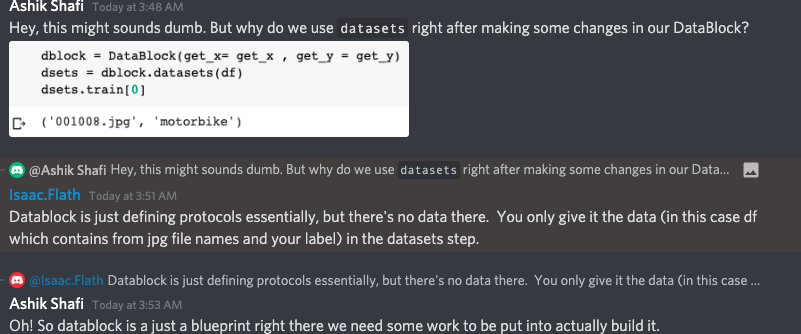

In [51]:
# Getting the x and y 

# dblock = DataBlock(get_x= lambda r:r['fname'] , get_y= lambda r:r['labels'] )

# Creating a function for getting y and x 

def get_x(r): return r['fname']

def get_y(r): return r['labels']

dblock = DataBlock(get_x= get_x , get_y = get_y) 
dsets = dblock.datasets(df)
dsets.train[5]

('002342.jpg', 'person')

But the independent variable (x) will need to be converted into a complete path, so that we can **open it as an image**, and the dependent variable should be split on the space character. Because they are tied together but in reality they are two different objects. 

In [52]:
# Making changes in get x and y 

def get_x(r): return path/'train'/r['fname']
def get_y(r): return r['labels'].split(' ')

# Creating the datablock and dsets again 

dblock = DataBlock(get_x = get_x , get_y = get_y)
dsets = dblock.datasets(df)

# Now looking into 
dsets.train[5]

(Path('/root/.fastai/data/pascal_2007/train/006702.jpg'), ['aeroplane'])

Alrighty! We got the path now but how do we open the images and do conversion on tensors? 

For this we need to use a set of transforms, block types will provide us with those transforms. The blocks we have seen so far are `ImageBlock` and `CategoryBlock`sure we can use the same but with one exception. We can't use the `CategoryBlock` in this problem, well it expects for only a single integer but in our case we need to have multiple labels for each item. 

To solve this we use `MultiCategoryBlock`, this can expects to recieve a list of strings as have in this case. 

In [53]:
# Using the Blocks 

dblock = DataBlock(blocks=(ImageBlock , MultiCategoryBlock) , get_x= get_x , get_y= get_y) # a blueprint 
dsets = dblock.datasets(df)
dsets.train[5]


(PILImage mode=RGB size=500x375,
 TensorMultiCategory([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 0.]))

If we take a look, the list of categories is not encoded in the same way that it was for the regular `CategoryBlock`, well in that case we had a single integer representing which category was present. 

For instance is it a cat? (or) is this an abyssinian cat? 

In that case we had a list of `0s` with a `1` in any position where that category is present.

In here if there is a `1` in the second and fourth positions, that means vocab items two and four are present in this image. This is known as one-hot encoding. 

The reason we can't easily just use a list of category indices is that each list would be of different length, and Pytorch requires tensors, where everything has to be same length.

In [54]:
# Checking the categories 

idxs = torch.where(dsets.train[0][1] == 1.)[0]
dsets.train.vocab[idxs]

(#3) ['car','motorbike','person']

With Numpy arrays and Pytorch Tensors and fastai's L class we can index directly using a list or vector. 

For now we have ignored the column `is_valid` up until now, which means that DataBlock has been using a random split by default. To choose the elements of our validation set, we need to write a function and pass it to splitter. 

It will take the items (in here our whole DataFrame) and must return two (or more) list of integers.

In [55]:
def splitter(df):
  train = df.index[~df['is_valid']].tolist()
  valid = df.index[df['is_valid']].tolist()
  return train , valid

In [56]:
df['is_valid'].value_counts()

True     2510
False    2501
Name: is_valid, dtype: int64

In [57]:
dblock = DataBlock(blocks = (ImageBlock , MultiCategoryBlock),  
                   splitter = splitter , 
                   get_x = get_x , 
                   get_y = get_y)

dsets = dblock.datasets(df)
dsets.train[4]

(PILImage mode=RGB size=500x281,
 TensorMultiCategory([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
         0., 0.]))

As we discussed a `DataLoader` collates the items from a Dataset into a mini-batch. This is a tuple of tensors, where each tensor simply stacks the items from that location in the Dataset item. 

Now we gotta make sure every item is of same size before putting them into a `DataLoaders`, we use `RandomResizedCrop`.

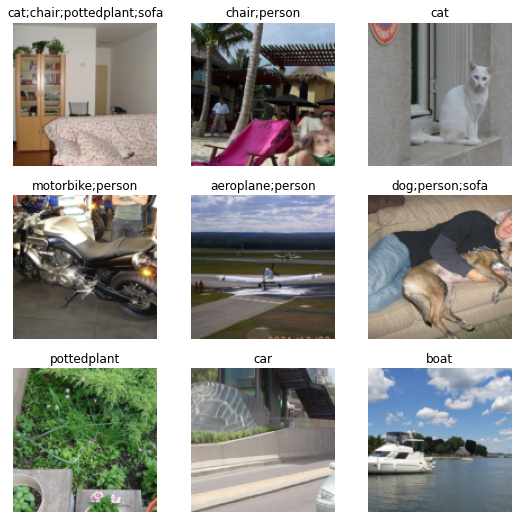

In [58]:
dblock = DataBlock(blocks=(ImageBlock , MultiCategoryBlock) , 
                   splitter = splitter , 
                   get_x = get_x , 
                   get_y = get_y , 
                   item_tfms = RandomResizedCrop(128 , min_scale=0.353))

# Putting into a Dataloader
dls = dblock.dataloaders(df)

# Displaying a sample of our data
dls.show_batch()